In [1]:
import yaml
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

In [2]:
file = "/sim_ws/src/f1tenth_gym_ros/race_logs/race_log_20250718_052046.csv"
racetrack = "/sim_ws/src/f1tenth_gym_ros/tracks/levine_closed.csv"

MAP_NAME = "levine_closed"
map_img_file = f"/sim_ws/src/f1tenth_gym_ros/maps/{MAP_NAME}.png"
map_yaml_file = f"/sim_ws/src/f1tenth_gym_ros/maps/{MAP_NAME}.yaml"

map_config = yaml.safe_load(open(map_yaml_file, 'r'))
map_resolution = map_config['resolution']
map_origin = map_config['origin']

map_img = np.array(Image.open(map_img_file).transpose(Image.FLIP_TOP_BOTTOM))
map_height, map_width = map_img.shape

race_data = pd.read_csv(file)
print(f"Shape of the file: {race_data.shape}")

pos_x, pos_y = race_data['pos_x'].values[::30], race_data['pos_y'].values[::30]
lin_vel_x = race_data['lin_vel_x'].values[::30]
time = race_data['time'].values[::30]

optim_racedata = pd.read_csv(racetrack, header=0, names=["x", "y", "vel"])
x_optim, y_optim = optim_racedata["x"].values, optim_racedata["y"].values

Shape of the file: (11700, 5)


In [3]:
pos_x -= map_origin[0]
pos_y -= map_origin[1]

pos_x /= map_resolution
pos_y /= map_resolution

x_optim -= map_origin[0]
y_optim -= map_origin[0]

x_optim /= map_resolution
y_optim /= map_resolution

In [4]:
start_x, start_y = pos_x[0], pos_y[0]

min_dist = np.inf
for i in range(2, len(pos_x)):
    dist = np.hypot(pos_x[i]-start_x, pos_y[i]-start_y)
    if dist < min_dist:
        min_dist = dist
        min_idx = i

lap_time = round(time[min_idx] - time[0], 3)

In [5]:
optim_path = np.vstack((x_optim, y_optim)).T
tracked_path = np.vstack((pos_x, pos_y)).T

tree = cKDTree(optim_path)
dists, _ = tree.query(tracked_path)

mean_error = np.mean(dists)
max_error = np.max(dists)
std_error = np.std(dists)

max_error_idx = np.argmax(dists)
max_error_point = tracked_path[max_error_idx]
closest_on_optim = optim_path[tree.query(tracked_path[max_error_idx])[1]]

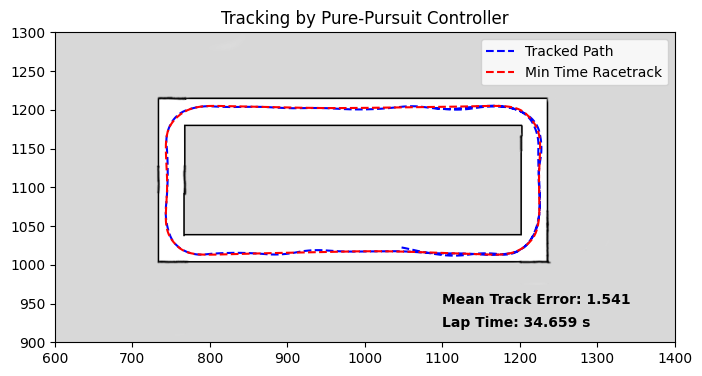

In [6]:
plt.figure(figsize=(8, 8))

plt.imshow(map_img, cmap='gray')
plt.plot(pos_x, pos_y, 'b--', label="Tracked Path")
plt.plot(x_optim, y_optim, 'r--', label="Min Time Racetrack")

plt.xlim(600, 1400)
plt.ylim(900, 1300)

plt.title("Tracking by Pure-Pursuit Controller")
plt.text(x=1100, y=950, s=f"Mean Track Error: {mean_error:.3f}", fontweight='heavy')
plt.text(x=1100, y=920, s=f"Lap Time: {lap_time} s", fontweight='heavy')
plt.legend(loc='upper right')
plt.show()

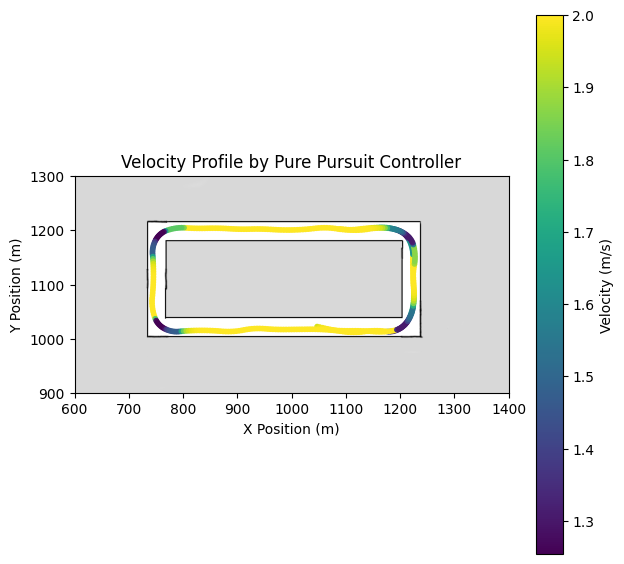

In [7]:
plt.figure(figsize=(7, 7))
sc = plt.scatter(pos_x, pos_y, c=lin_vel_x, cmap='viridis', s=10)
plt.colorbar(sc, label='Velocity (m/s)')
plt.imshow(map_img, cmap='gray')

plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.title("Velocity Profile by Pure Pursuit Controller")
plt.xlim(600, 1400)
plt.ylim(900, 1300)
plt.grid(False)
plt.show()